# Local oscillator optimization - Complex seed

### Separable JSA for photon triplets-Ideal case for waveguides

### Conditions: phase-matching, group-velocity matching, $\beta_F\gg\beta_P$

### Minimal working example

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.io import savemat
from matplotlib.ticker import FormatStrFormatter
import jaxopt
from jax import random
import jax
jax.config.update("jax_enable_x64", True)
import scipy
from jax import jit

from topdc_calc import topdc_calc

import numpy as np

# Set the default device to CPU
jax.config.update('jax_default_device', jax.devices('cpu')[0])

#### Import the dispersion parameters

In [2]:
#Dispersion import 

dispdata=np.load('disp_data.npy',allow_pickle=True).item()
omf=dispdata['omf']
triplet_neff=dispdata['triplet_neff']
omp=dispdata['omp']
pump_neff=dispdata['pump_neff']
wp_cutoff=9.8  #Pump mode cutoff frequency in 10^14 rad/s

test=topdc_calc(omf,triplet_neff,omp,pump_neff,wp_cutoff)

In [3]:
# Declaration of variables

c0=3 # Velocity of light in vacuum in um/(1e-14 s)
L=300000 # Waveguide length in um ->10000 um=1 cm

wf0=test.w_pm(13)   # Triplet phase-matching frequency in 10^14 rad/s (The input parameter 13  is the initial guess for the triplet central frequency--> You can check this by plotting the dispersion of the pump and triplet modes) 
wp0=3*wf0   # Pump phase-matching frequency in 10^14 rad/s 

#### Evaluation of the JSA

We are going to filter outside the frequencies $[11.5,15]\times~10^{14}$ rad/s.

In [4]:
wlow=11.5 # Filter lower limit
whigh=15  # Filter higher limit
topdc_calcs=test.topdc_scaled_auto(L,wp0,wlow,whigh)  # Evaluation of the jsa calculation function

Zeroth-order phase-matching (L/2)Δk=5.329070518200751e-10
Relative slowness s=1/vp-1/vf=1.7678895546935358e-05 [1/(10^8 m/s)]
Group velocity dispersion of the triplet mode: 0.021901719214517668 [fs^2/um]
Group velocity dispersion of the pump mode: -0.006399378811028367 [fs^2/um]


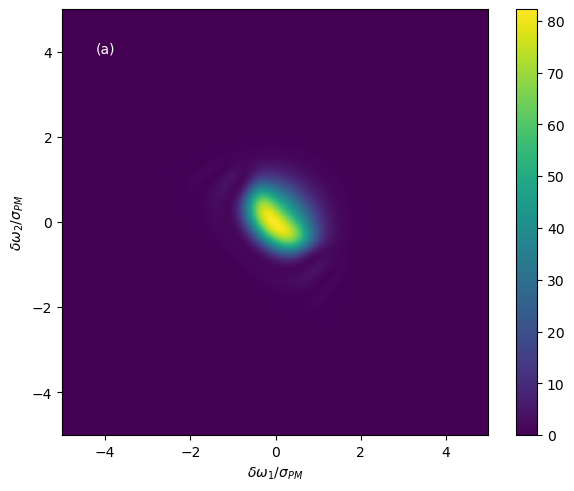

In [5]:
fig1, axs1 = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)
c1=axs1.pcolor(topdc_calcs.omega,topdc_calcs.omega, topdc_calcs.jsa_proj, rasterized=True)

axs1.set_box_aspect(1)
axs1.set_xlabel(r'$\delta\omega_{1}/\sigma_{PM}$')
axs1.set_ylabel(r'$\delta\omega_{2}/\sigma_{PM}$')

fig1.colorbar(c1)
fig1.text(0.26,0.9, '(a)',color='white')
fig1.set_edgecolor('none')
plt.gca().set_aspect('equal')

plt.show()

#### Reduced density matrix and its eigenvalue decomposition

In [6]:
## JSA data
jsa_data=topdc_calcs.jsa/jnp.linalg.norm(topdc_calcs.jsa)
rho=topdc_calcs.density_matrix

In [7]:
vals,vects=jnp.linalg.eigh(rho)
print(jnp.einsum("ijk,i,j,k",jsa_data,vects[:,-1],vects[:,-1],vects[:,-1]))

0.8632724008725378


## Local oscillator optimization - Gradient descent

In [8]:
# Objective function
def objective_func(f):
    """
    Parameters
    ----------
    f:  Local oscillator spectrum. 1d array containing complex numbers, 
        half of the components correspond to the real part of the distribution, 
        and the last half correspond to the imaginary part. 
    
    Returns
    -------
    Negative overlap between the jsa and the local oscillator function, 
    as defined in the paper.
    """
    fre,fim=jnp.split(f,[int(f.size/2)])
    fnorm=(fre+fim*1j)/jnp.linalg.norm(fre+fim*1j)
    jsa_overlap=jnp.abs(jnp.einsum("ijk,i,j,k",jsa_data,fnorm,fnorm,fnorm))
    return -jsa_overlap # We define it negative, because we are using the minimize solver, but our goal is to actually maximize it

In [9]:
def optimizer(initial_seed):
    """
    Parameters
    ----------
    initial_seed:  Initial seed-Local oscillator spectrum. 1d array containing complex numbers. 
    
    Returns
    -------
    result.params: Optimized local oscillator spectrum. Half of the components correspond to the real part of the distribution, 
        and the last half correspond to the imaginary part. 
    result.state.fun_val: Value of the negative overlap between the jsa and the local oscillator distribution,
                        as defined in the paper.
    """
    solver=jaxopt.ScipyMinimize(fun=objective_func, maxiter=5000, tol=1e-10)
    # Running the optimizer:
    result=solver.run(initial_seed)
    ans=(result.params,result.state.fun_val)
    return ans

In [10]:
#Seed: Let's try first with a complex gaussian
keygauss=random.PRNGKey(42) 
phase=random.uniform(keygauss,shape=(topdc_calcs.omega.shape),minval=0.0) #Random phase
seed_gauss_gd_re=jnp.exp(-(1/2)*(topdc_calcs.omega)**2)*jnp.cos(phase) # Seed initialization-Real part -Random phase
seed_gauss_gd_im=jnp.exp(-(1/2)*(topdc_calcs.omega)**2)*jnp.sin(phase) # Seed initialization-Imaginary part -Random phase

seed_gauss_gd=jnp.concatenate([seed_gauss_gd_re,seed_gauss_gd_im]) # Concatenate real and imaginary parts

result_gauss_gd=optimizer(seed_gauss_gd) # Run optimizer
mode_gauss_optimgd=result_gauss_gd[0]/jnp.linalg.norm(result_gauss_gd[0]) # Local oscillator distribution obtained from the optimizer
mode_gauss_optimgd_re,mode_gauss_optimgd_im=jnp.split(mode_gauss_optimgd,2) # Split the real and imaginary parts of the local oscillator optimal distribution
overlap_gauss_optimgd=result_gauss_gd[1]  # Value of the overlap with the jsa
print(overlap_gauss_optimgd)

-0.8661221712776435


In [11]:
## Let's check with a complex seed - uniform distribution 
keygd=random.PRNGKey(74291)
keyph2=random.PRNGKey(42)  
phase2=random.uniform(keyph2,shape=(topdc_calcs.omega.shape),minval=0.0)  #Random phase
seed_uniformgd_re=random.uniform(keygd,shape=(topdc_calcs.omega.shape),minval=0.0)*jnp.cos(phase2)  # Seed initialization-Real part-Random amplitude -Random phase
seed_uniformgd_im=random.uniform(keygd,shape=(topdc_calcs.omega.shape),minval=0.0)*jnp.sin(phase2) # Seed initialization-Imaginary part-Random amplitude -Random phase

seed_uniformgd=jnp.concatenate([seed_uniformgd_re,seed_uniformgd_im]) # Concatenate real and imaginary parts

result_uniform_gd=optimizer(seed_uniformgd) # Run optimizer 
mode_uniform_optimgd=result_uniform_gd[0]/jnp.linalg.norm(result_uniform_gd[0]) # Local oscillator distribution obtained from the optimizer
mode_uniform_optimgd_re,mode_uniform_optimgd_im=jnp.split(mode_uniform_optimgd,2) # Split the real and imaginary parts of the local oscillator optimal distribution

overlap_uniform_optimgd=result_uniform_gd[1] # Value of the overlap with the jsa
print(overlap_uniform_optimgd)

-0.8661221712776294


In [12]:
## Let's check with another complex seed - uniform distribution 
keygd2r=random.PRNGKey(74291)
keygd2i=random.PRNGKey(74290)  
seed_uniformgd_re2=random.uniform(keygd2r,shape=(topdc_calcs.omega.shape),minval=0.0) # Seed initialization-Real part-Random amplitude
seed_uniformgd_im2=random.uniform(keygd2i,shape=(topdc_calcs.omega.shape),minval=0.0) # Seed initialization-Imaginary part-Random amplitude

seed_uniformgd2=jnp.concatenate([seed_uniformgd_re2,seed_uniformgd_im2]) # Concatenate real and imaginary parts

result_uniform_gd2=optimizer(seed_uniformgd2) # Run optimizer
mode_uniform_optimgd2=result_uniform_gd2[0]/jnp.linalg.norm(result_uniform_gd2[0]) # Local oscillator distribution obtained from the optimizer
mode_uniform_optimgd_re2,mode_uniform_optimgd_im2=jnp.split(mode_uniform_optimgd2,2) # Split the real and imaginary parts of the local oscillator optimal distribution

overlap_uniform_optimgd2=result_uniform_gd2[1] # Value of the overlap with the jsa
print(overlap_uniform_optimgd2)

-0.8661221712776325


## Local oscillator optimization - Basin hopping

In [13]:
### The following function returns the function value and the gradient:
objective_func_value_grad = jit(jax.value_and_grad(objective_func, argnums=0))

In [14]:
def optimizer_basinhop(ini_seed):
    """
    Parameters
    ----------
    ini_seed: Initial seed-Local oscillator spectrum. 1d array containing complex numbers. 
    
    
    Returns
    -------
    Results of the basin hopping Scipy optimizer with 'L-BFGS-B' method for local
    optimization: (solution.x, solution.fun, solution.success*1.0) where
    solution.x is the local oscillator distribution that optimize the objective function,
    solution.fun is the negative JSA overlap value with an optimal local oscillator,
    solution.success*1.0 is 1.0 if the optimizer is successful and 0.0 otherwise
    """

    ### Options for the optimizer:
    minimizer_kwargs = {
        "method": "L-BFGS-B",  # Local optimizer method
        "jac": True,  # JAX gradient provides gradients automatically
        "options": {"maxiter": 1000, "ftol": 1e-9}
    }

    ### Optimizing using the basinhoping optimizer with the gradient and the initial
    #### seed passed to it (note that the objective function contains the normalization)
    solution = scipy.optimize.basinhopping(
        func=objective_func_value_grad,
        x0=ini_seed,
        niter=100,
        T=1.0,
        stepsize=0.5,
        minimizer_kwargs=minimizer_kwargs,
    )

    mode_unnormalized = solution.x
    mode_norm = jnp.linalg.norm(solution.x)

    optimal_mode = mode_unnormalized/mode_norm

    return (optimal_mode, solution.fun, solution.success * 1.0)
 

In [15]:
#Seed: Let's try first with a complex gaussian as defined above
result_gauss_bh=optimizer_basinhop(seed_gauss_gd) # Run optimizer with the gaussian seed
mode_gauss_optimbh=result_gauss_bh[0] # Local oscillator distribution obtained from the optimizer
mode_gauss_optimbh_re,mode_gauss_optimbh_im=jnp.split(mode_gauss_optimbh,2) # Split the real and imaginary parts of the local oscillator optimal distribution
overlap_gauss_optimbh=result_gauss_bh[1] # Value of the overlap with the jsa
print(overlap_gauss_optimbh)

-0.8661221337876356


In [16]:
## Let's check with a complex seed- uniform distribution
keybh=random.PRNGKey(74291) 

seed_uniformbh_re=random.uniform(keybh,shape=(topdc_calcs.omega.shape),minval=0.0)*jnp.cos(phase2) # Seed initialization-Real part-Random amplitude -Random phase
seed_uniformbh_im=random.uniform(keybh,shape=(topdc_calcs.omega.shape),minval=0.0)*jnp.sin(phase2) # Seed initialization-Imaginary part-Random amplitude -Random phase

seed_uniformbh=jnp.concatenate([seed_uniformbh_re,seed_uniformbh_im]) # Concatenate real and imaginary parts

result_uniform_bh=optimizer_basinhop(seed_uniformbh)  # Run optimizer-Basin hopping
mode_uniform_optimbh=result_uniform_bh[0] # Local oscillator distribution obtained from the optimizer
mode_uniform_optimbh_re,mode_uniform_optimbh_im=jnp.split(mode_uniform_optimbh,2) # Split the real and imaginary parts of the local oscillator optimal distribution

overlap_uniform_optimbh=result_uniform_bh[1] # Value of the overlap with the jsa
print(overlap_uniform_optimbh)

-0.8661221349040049


In [17]:
## Let's check with another complex seed- uniform distribution
keybh2re=random.PRNGKey(74289) 
keybh2im=random.PRNGKey(74292) 

seed_uniformbh_re2=random.uniform(keybh2re,shape=(topdc_calcs.omega.shape),minval=0.0) # Seed initialization-Real part-Random amplitude
seed_uniformbh_im2=random.uniform(keybh2im,shape=(topdc_calcs.omega.shape),minval=0.0) # Seed initialization-Imaginary part-Random amplitude

seed_uniformbh2=jnp.concatenate([seed_uniformbh_re2,seed_uniformbh_im2]) # Concatenate real and imaginary parts

result_uniform_bh2=optimizer_basinhop(seed_uniformbh2) # Run optimizer-Basin hopping
mode_uniform_optimbh2=result_uniform_bh2[0] # Local oscillator distribution obtained from the optimizer
mode_uniform_optimbh_re2,mode_uniform_optimbh_im2=jnp.split(mode_uniform_optimbh2,2) # Split the real and imaginary parts of the local oscillator optimal distribution

overlap_uniform_optimbh2=result_uniform_bh2[1] # Value of the overlap with the jsa
print(overlap_uniform_optimbh2)

-0.8661221507081874


### Overlap and gradient

In [18]:
# Amplitude of the optimized local oscillator for the gaussian and random uniform seeds, using both gradient descent and basin hopping algorithms

mode_gauss_optimgd_amp=jnp.sqrt(mode_gauss_optimgd_re**2+mode_gauss_optimgd_im**2)
mode_uniform_optimgd_amp=jnp.sqrt(mode_uniform_optimgd_re**2+mode_uniform_optimgd_im**2)
mode_uniform_optimgd_amp2=jnp.sqrt(mode_uniform_optimgd_re2**2+mode_uniform_optimgd_im2**2)
mode_gauss_optimbh_amp=jnp.sqrt(mode_gauss_optimbh_re**2+mode_gauss_optimbh_im**2)
mode_uniform_optimbh_amp=jnp.sqrt(mode_uniform_optimbh_re**2+mode_uniform_optimbh_im**2)
mode_uniform_optimbh_amp2=jnp.sqrt(mode_uniform_optimbh_re2**2+mode_uniform_optimbh_im2**2)

In [19]:
# Overlap between the optimized local oscillator amplitudes and the dominant mode of the eigendecomposition of the reduced density matrix

overlap_eigen_gauss=jnp.dot(mode_gauss_optimgd_amp,vects[:,-1])
overlap_eigen_unif=jnp.dot(mode_uniform_optimgd_amp,vects[:,-1])
overlap_eigen_unif2=jnp.dot(mode_uniform_optimgd_amp2,vects[:,-1])
overlap_eigen_gaussbh=jnp.dot(mode_gauss_optimbh_amp,vects[:,-1])
overlap_eigen_unifbh=jnp.dot(mode_uniform_optimbh_amp,vects[:,-1])
overlap_eigen_unifbh2=jnp.dot(mode_uniform_optimbh_amp2,vects[:,-1])
print(overlap_eigen_gauss)
print(overlap_eigen_unif)
print(overlap_eigen_gaussbh)
print(overlap_eigen_unifbh)

0.9904106173353444
0.9904106189363473
0.9904074839487602
0.9904144140938824


In [20]:
func_value_grad=jax.value_and_grad(objective_func,argnums=0)
valeig,gradeig=func_value_grad(jnp.concatenate([vects[:,-1],jnp.zeros_like(vects[:,-1])]))
valcoptggd,gradcoptggd=func_value_grad(mode_gauss_optimgd)
valcoptugd,gradcoptugd=func_value_grad(mode_uniform_optimgd)
valcoptugd2,gradcoptugd2=func_value_grad(mode_uniform_optimgd2)
valcoptgbh,gradcoptgbh=func_value_grad(mode_gauss_optimbh)
valcoptubh,gradcoptubh=func_value_grad(mode_uniform_optimbh)
valcoptubh2,gradcoptubh2=func_value_grad(mode_uniform_optimbh2)
print('Func gradient with Dominant mode of rho: '+str(jnp.linalg.norm(gradeig))) # Dominant mode of rho
print('Func gradient with Gauss seed-Gradient descent method: '+str(jnp.linalg.norm(gradcoptggd)))  #Gauss seed-Gradient descent
print('Func gradient with Uniform seed - Gradient descent method: '+str(jnp.linalg.norm(gradcoptugd))) # Uniform seed - Gradient descent
print('Func gradient with Uniform seed 2- Gradient descent method: '+str(jnp.linalg.norm(gradcoptugd2))) # Uniform seed - Gradient descent
print('Func gradient with Gauss seed-Basin hopping method: '+str(jnp.linalg.norm(gradcoptgbh))) # Gauss seed-Basin hopping
print('Func gradient with  Uniform seed - Basin hopping method: '+str(jnp.linalg.norm(gradcoptubh))) # Uniform seed - Basin hopping
print('Func gradient with  Uniform seed 2 - Basin hopping method: '+str(jnp.linalg.norm(gradcoptubh2))) # Uniform seed - Basin hopping

Func gradient with Dominant mode of rho: 0.1430848462104703
Func gradient with Gauss seed-Gradient descent method: 6.480458744127263e-08
Func gradient with Uniform seed - Gradient descent method: 2.6444704133847545e-07
Func gradient with Uniform seed 2- Gradient descent method: 2.2350216318838534e-07
Func gradient with Gauss seed-Basin hopping method: 0.0004155758585321694
Func gradient with  Uniform seed - Basin hopping method: 0.00046449715227319044
Func gradient with  Uniform seed 2 - Basin hopping method: 0.00033417335360028984


### Plot

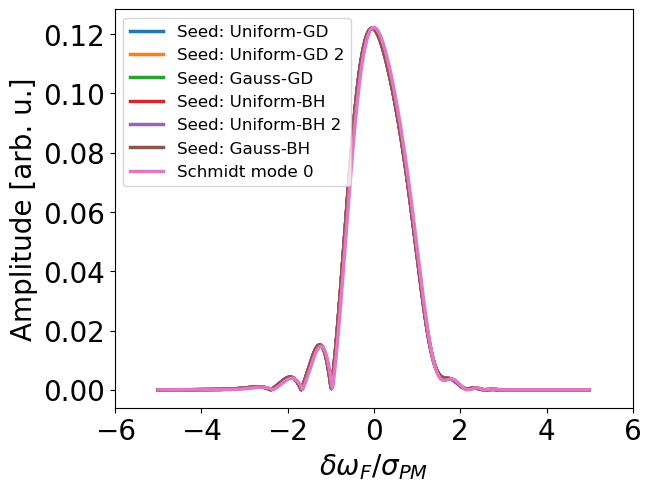

In [21]:
font={'size':20}
plt.rc('font',**font)

figm, axsm = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

plt.plot(topdc_calcs.omega,mode_uniform_optimgd_amp,label='Seed: Uniform-GD',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_uniform_optimgd_amp2,label='Seed: Uniform-GD 2',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_gauss_optimgd_amp,label='Seed: Gauss-GD',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_uniform_optimbh_amp,label='Seed: Uniform-BH',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_uniform_optimbh_amp2,label='Seed: Uniform-BH 2',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_gauss_optimbh_amp,label='Seed: Gauss-BH',linewidth=2.5)

plt.plot(topdc_calcs.omega,jnp.abs(vects[:,-1]),label='Schmidt mode 0',linewidth=2.5)
plt.xlabel(r'$\delta\omega_{F}/\sigma_{PM}$')
plt.ylabel("Amplitude [arb. u.]") 

plt.xlim(-6,6)
plt.legend(fontsize=12)  


plt.show()

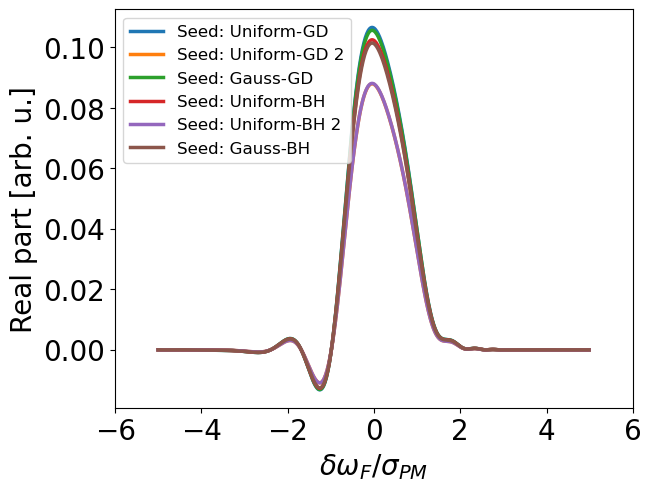

In [22]:
font={'size':20}
plt.rc('font',**font)

figm, axsm = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

plt.plot(topdc_calcs.omega,mode_uniform_optimgd_re,label='Seed: Uniform-GD',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_uniform_optimgd_re2,label='Seed: Uniform-GD 2',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_gauss_optimgd_re,label='Seed: Gauss-GD',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_uniform_optimbh_re,label='Seed: Uniform-BH',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_uniform_optimbh_re2,label='Seed: Uniform-BH 2',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_gauss_optimbh_re,label='Seed: Gauss-BH',linewidth=2.5)
plt.xlabel(r'$\delta\omega_{F}/\sigma_{PM}$')
plt.ylabel("Real part [arb. u.]") 

plt.xlim(-6,6)
plt.legend(fontsize=12)  


plt.show()

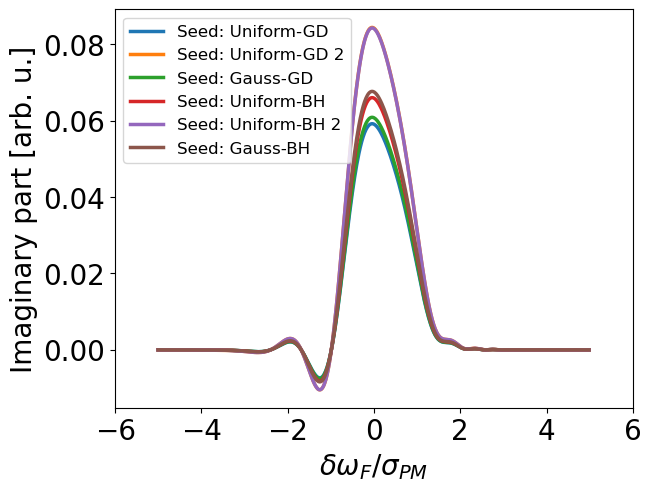

In [23]:
font={'size':20}
plt.rc('font',**font)

figm, axsm = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

plt.plot(topdc_calcs.omega,mode_uniform_optimgd_im,label='Seed: Uniform-GD',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_uniform_optimgd_im2,label='Seed: Uniform-GD 2',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_gauss_optimgd_im,label='Seed: Gauss-GD',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_uniform_optimbh_im,label='Seed: Uniform-BH',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_uniform_optimbh_im2,label='Seed: Uniform-BH 2',linewidth=2.5)
plt.plot(topdc_calcs.omega,mode_gauss_optimbh_im,label='Seed: Gauss-BH',linewidth=2.5)
plt.xlabel(r'$\delta\omega_{F}/\sigma_{PM}$')
plt.ylabel("Imaginary part [arb. u.]") 

plt.xlim(-6,6)
plt.legend(fontsize=12)  


plt.show()

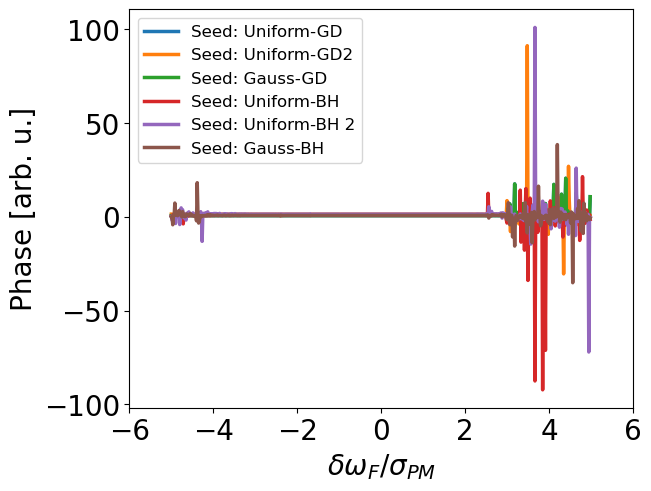

In [24]:
font={'size':20}
plt.rc('font',**font)

figm, axsm = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

plt.plot(topdc_calcs.omega,jnp.tan(mode_uniform_optimgd_im/mode_uniform_optimgd_re),label='Seed: Uniform-GD',linewidth=2.5)
plt.plot(topdc_calcs.omega,jnp.tan(mode_uniform_optimgd_im2/mode_uniform_optimgd_re2),label='Seed: Uniform-GD2',linewidth=2.5)
plt.plot(topdc_calcs.omega,jnp.tan(mode_gauss_optimgd_im/mode_gauss_optimgd_re),label='Seed: Gauss-GD',linewidth=2.5)
plt.plot(topdc_calcs.omega,jnp.tan(mode_uniform_optimbh_im/mode_uniform_optimbh_re),label='Seed: Uniform-BH',linewidth=2.5)
plt.plot(topdc_calcs.omega,jnp.tan(mode_uniform_optimbh_im2/mode_uniform_optimbh_re2),label='Seed: Uniform-BH 2',linewidth=2.5)
plt.plot(topdc_calcs.omega,jnp.tan(mode_gauss_optimbh_im/mode_gauss_optimbh_re),label='Seed: Gauss-BH',linewidth=2.5)
plt.xlabel(r'$\delta\omega_{F}/\sigma_{PM}$')
plt.ylabel("Phase [arb. u.]") 

plt.xlim(-6,6)
plt.legend(fontsize=12)  


plt.show()